# MTA Turnstile Data Analysis: Benford's Law

Does MTA Turnstile Data follow [Benford's Law](https://en.wikipedia.org/wiki/Benford%27s_law)?

I recently learned about Benford's Law through the [Netflix Series *Connected* with Latif Nasser](https://www.netflix.com/title/81031737#:~:text=Digits&text=Latif%20explores%20a%20law%20of,and%20perhaps%20the%20entire%20universe.). Episode 4: 'Digits' explores how Benford's Law applies to music, social media, tax fraud, and more. It's a fun show and I'd highly recommend checking it out if you can!

Since that episode, I'd had it in the back of my mind that I wanted to explore some sort of dataset to check for *Benfordness*. Our first project at [Metis](https://www.thisismetis.com/) was to conduct some exploratory data analysis on the [MTA Turnstile dataset](http://web.mta.info/developers/turnstile.html) and give a presentation on a given prompt.

With the presentation behind me, I decided to dig a little more into the data and see how well the MTA turnstile data fit Benford's Law. 

A quick primer on Benford's Law from Wikipedia

> **Benford's law**, also called the **Newcomb–Benford law**, the **law of anomalous numbers**, or the **first-digit law**, is an observation about the frequency distribution of leading digits in many real-life sets of numerical data. The law states that in many naturally occurring collections of numbers, the leading digit is likely to be small. For example, in sets that obey the law, the number 1 appears as the leading significant digit about 30% of the time, while 9 appears as the leading significant digit less than 5% of the time. If the digits were distributed uniformly, they would each occur about 11.1% of the time. Benford's law also makes predictions about the distribution of second digits, third digits, digit combinations, and so on.

You can see Benford's illustrated in the figure below. 

In [1]:
import datetime
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

### Benford's Law

#### Table Representation

In [2]:
benfords = pd.DataFrame({'digit': list(range(1, 10)), 
                       'percent': [30.1, 17.6, 12.5, 9.7, 7.9, 6.7, 5.8, 5.1, 4.6]}, 
                       index=list(range(1, 10)))
benfords

,digit,percent
1,1,30.1
2,2,17.6
3,3,12.5
4,4,9.7
5,5,7.9
6,6,6.7
7,7,5.8
8,8,5.1
9,9,4.6


#### Visual Representation

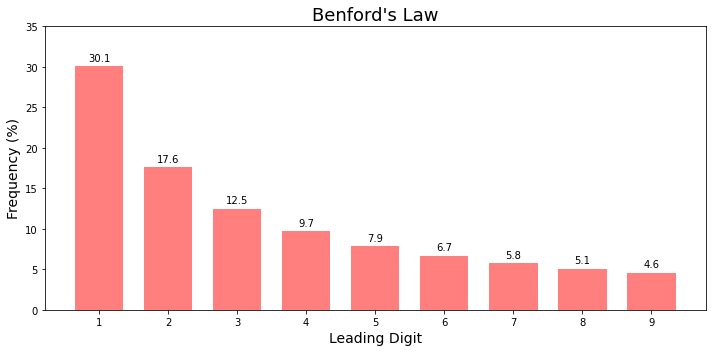

In [3]:
digits = list(range(1, 10))
benfords_percents = benfords['percent']

x = np.arange(len(digits))  # the label locations
width = 0.7  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 5))
benford_bars = ax.bar(x, benfords_percents, width, color='red', alpha=0.5)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Frequency (%)', fontsize=14)
ax.set_xlabel('Leading Digit', fontsize=14)
ax.set_title("Benford's Law", fontsize=18)
ax.set_xticks(x)
ax.set_ylim(0, 35)
ax.set_xticklabels(digits)

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(benford_bars)

fig.tight_layout()

#plt.savefig('benfords.png')
plt.show();

### Sources & references

- [MTA Turnstile Data](http://web.mta.info/developers/turnstile.html)
- [MTA Turnstile Data - Codebook](http://web.mta.info/developers/resources/nyct/turnstile/ts_Field_Description.txt)
- [Kaggle: MTA Turnstile Data Analysis](https://www.kaggle.com/nieyuqi/mta-turnstile-data-analysis)

## Data Import and Scrubbing

Importing four weeks worth of data -- the last four available weeks at the time of this study.

In [4]:
def get_data(week_nums):
    url = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt"
    dfs = []
    for week_num in week_nums:
        file_url = url.format(week_num)
        dfs.append(pd.read_csv(file_url))
    return pd.concat(dfs)

In [5]:
# Grab last 4 weeks of data: 
import_weeks = [200926, 200919, 200912, 200905]

mta_raw = get_data(import_weeks)

In [6]:
mta_raw.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/19/2020,00:00:00,REGULAR,7460236,2537220
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/19/2020,04:00:00,REGULAR,7460241,2537220
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/19/2020,08:00:00,REGULAR,7460260,2537239
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/19/2020,12:00:00,REGULAR,7460289,2537289
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/19/2020,16:00:00,REGULAR,7460377,2537315


In [7]:
print("Number of rows: {}".format(len(mta_raw)))

Number of rows: 838127


### Formatting New and Existing Columns

In [8]:
# Rename columns for easier coding later

mta_raw.columns = ['ca',
                   'unit',
                  'scp',
                  'station',
                  'linename',
                  'division',
                  'date',
                  'time',
                  'desc',
                  'entries_cum',
                  'exits_cum']

In [9]:
# Create a timestamp column with datetime object
# Convert date data to datetime object

mta_raw['timestamp'] = pd.to_datetime(mta_raw['date'] + ' ' + mta_raw['time'])
mta_raw['date'] = pd.to_datetime(mta_raw['date'])

In [10]:
# Create turnstile column as proxy for unique identifier
mta_raw['turnstile'] = mta_raw['station'] + '-' + mta_raw['ca'] + '-' + mta_raw['unit'] + '-' + mta_raw['scp']

### Checking for Duplicates

In [11]:
# Checking for duplicates
dupes = mta_raw.groupby(['turnstile', 'timestamp'])['entries_cum'].count().reset_index().sort_values('entries_cum', ascending=False)

In [12]:
dupes = dupes[dupes['entries_cum'] > 1]
print('# of Duplicate Entries: {}'.format(len(dupes)))
dupes

# of Duplicate Entries: 15


,turnstile,timestamp,entries_cum
241767,59 ST-R245A-R051-01-00-00,2020-09-12 00:00:00,2
87080,181 ST-N007A-R174-00-00-00,2020-09-23 13:00:00,2
370702,BERGEN ST-N532-R129-00-00-00,2020-08-31 17:00:00,2
290519,86 ST-2 AVE-N701-R571-00-00-00,2020-09-24 09:00:00,2
778210,SUTTER AV-RUTLD-R627-R063-00-00-00,2020-09-07 16:00:00,2
87248,181 ST-N007A-R174-00-00-01,2020-09-23 13:00:00,2
778212,SUTTER AV-RUTLD-R627-R063-00-00-00,2020-09-08 00:00:00,2
778380,SUTTER AV-RUTLD-R627-R063-00-00-01,2020-09-08 00:00:00,2
778378,SUTTER AV-RUTLD-R627-R063-00-00-01,2020-09-07 16:00:00,2
233753,59 ST-A002-R051-02-00-00,2020-09-12 12:00:00,2


These duplicates exist when MTA does a `RECOVR AUD` entry - there are quite a few in this dataset, but these will be dealt with when I find the delta between cumulative entries/exits for each time period. 

In [13]:
mta_raw.desc.value_counts()

REGULAR       834643
RECOVR AUD      3484
Name: desc, dtype: int64

In [14]:
mta_raw[(mta_raw['turnstile']=='59 ST-R245A-R051-01-00-00') &
       (mta_raw['timestamp']=='2020-09-12 00:00:00')]

,ca,unit,scp,station,linename,division,date,time,desc,entries_cum,exits_cum,timestamp,turnstile
166509,R245A,R051,01-00-00,59 ST,456NQRW,IRT,2020-09-12,00:00:00,REGULAR,13703909,4892239,2020-09-12,59 ST-R245A-R051-01-00-00
166510,R245A,R051,01-00-00,59 ST,456NQRW,IRT,2020-09-12,00:00:00,RECOVR AUD,26726,3996,2020-09-12,59 ST-R245A-R051-01-00-00


In [15]:
mta_raw[(mta_raw['turnstile']=='181 ST-N007A-R174-00-00-00') &
       (mta_raw['timestamp']=='2020-09-23 13:00:00')]

,ca,unit,scp,station,linename,division,date,time,desc,entries_cum,exits_cum,timestamp,turnstile
46407,N007A,R174,00-00-00,181 ST,A,IND,2020-09-23,13:00:00,REGULAR,4,0,2020-09-23 13:00:00,181 ST-N007A-R174-00-00-00
46408,N007A,R174,00-00-00,181 ST,A,IND,2020-09-23,13:00:00,RECOVR AUD,10732094,11586103,2020-09-23 13:00:00,181 ST-N007A-R174-00-00-00


### Calculating actual entries & exits from cumulative figures

Taking the difference between entries to get the actual number of entries/exits foer each time period. 

The following block of code comes from [Kaggle: MTA Turnstile Data Analysis](https://www.kaggle.com/nieyuqi/mta-turnstile-data-analysis). Since some counters actually go *backwards*, I applied the `abs()` method to the end of these `.transform(pd.Series.diff)` lines. 

In [16]:
mta_sorted = mta_raw.sort_values(['turnstile', 'timestamp'])
mta_sorted = mta_sorted.reset_index(drop = True)

turnstile_grouped = mta_sorted.groupby(['turnstile'])

mta_sorted['entries'] = turnstile_grouped['entries_cum'].transform(pd.Series.diff).abs()
mta_sorted['exits'] = turnstile_grouped['exits_cum'].transform(pd.Series.diff).abs()

In [17]:
mta_sorted.head(3)

,ca,unit,scp,station,linename,division,date,time,desc,entries_cum,exits_cum,timestamp,turnstile,entries,exits
0,H007,R248,00-00-00,1 AV,L,BMT,2020-08-29,00:00:00,REGULAR,15470879,17378563,2020-08-29 00:00:00,1 AV-H007-R248-00-00-00,NaN,NaN
1,H007,R248,00-00-00,1 AV,L,BMT,2020-08-29,04:00:00,RECOVR AUD,15470881,17378580,2020-08-29 04:00:00,1 AV-H007-R248-00-00-00,2.0,17.0
2,H007,R248,00-00-00,1 AV,L,BMT,2020-08-29,08:00:00,REGULAR,15470894,17378700,2020-08-29 08:00:00,1 AV-H007-R248-00-00-00,13.0,120.0


### Dealing with outliers & NaN values

**Dealing with outliers and messy data**

Two messy data type:

* **Very large values:** some turnstile counts are unbelievably large. We'll set a threshold of 10,000 entries or exits per turnstile per time period (this translates to ~40 entries/exits per minute, which is feasible). Any values above this threshold will be converted to NaN and dropped.
* **Not a number (NaN):** the majority of these NaN values is because they were the start of our timeperiod for the turnstile and thus had no prior time period to calculate the actual values from the cumulative figures.

A third, **negative values** would have been handled above when we applied the `abs()` method above.

These cases will be converted to NaN (if not already NaN) and dropped from the dataset.

In [18]:
print('Number of negative entries: %d' %len(mta_sorted['entries'][mta_sorted['entries'] < 0]))
print('Number of negative exits: %d' %len(mta_sorted['exits'][mta_sorted['exits'] < 0]))
print('')
print('Number of entries > 10k: %d' %len(mta_sorted['entries'][mta_sorted['entries'] > 10000]))
print('Number of exits > 10k: %d' %len(mta_sorted['exits'][mta_sorted['exits'] > 10000]))
print('')
print('Number of NaN rows: %d' %len(mta_sorted[mta_sorted['entries'].isnull()]))

Number of negative entries: 0
Number of negative exits: 0

Number of entries > 10k: 157
Number of exits > 10k: 148

Number of NaN rows: 4981


In [19]:
# Filtering for values above our 10k threshold

ents_10k = mta_sorted.loc[:, 'entries'] > 10000
exits_10k = mta_sorted.loc[:, 'exits'] > 10000

In [20]:
# Converting negative and above threshold entries to Nan

mta_sorted.loc[ents_10k, 'entries'] = np.nan
mta_sorted.loc[exits_10k, 'exits'] = np.nan

In [21]:
print('Number of negative entries: %d' %len(mta_sorted['entries'][mta_sorted['entries'] < 0]))
print('Number of negative exits: %d' %len(mta_sorted['exits'][mta_sorted['exits'] < 0]))
print('')
print('Number of entries > 10k: %d' %len(mta_sorted['entries'][mta_sorted['entries'] > 10000]))
print('Number of exits > 10k: %d' %len(mta_sorted['exits'][mta_sorted['exits'] > 10000]))
print('')
print('Number of NaN rows: %d' %len(mta_sorted[mta_sorted['entries'].isnull()]))

Number of negative entries: 0
Number of negative exits: 0

Number of entries > 10k: 0
Number of exits > 10k: 0

Number of NaN rows: 5138


In [22]:
# Dropping na values

mta_sorted.dropna(inplace=True)

In [23]:
print('Number of NaN rows: %d' %len(mta_sorted[mta_sorted['entries'].isnull()]))

Number of NaN rows: 0


In [24]:
mta_sorted['total'] = mta_sorted['entries'] + mta_sorted['exits']

In [25]:
mta_sorted['weekday'] = mta_sorted['date'].dt.day_name()
mta_sorted['weekday_num'] = mta_sorted['date'].dt.dayofweek

In [26]:
mta_sorted.head(3)

,ca,unit,scp,station,linename,division,date,time,desc,entries_cum,exits_cum,timestamp,turnstile,entries,exits,total,weekday,weekday_num
1,H007,R248,00-00-00,1 AV,L,BMT,2020-08-29,04:00:00,RECOVR AUD,15470881,17378580,2020-08-29 04:00:00,1 AV-H007-R248-00-00-00,2.0,17.0,19.0,Saturday,5
2,H007,R248,00-00-00,1 AV,L,BMT,2020-08-29,08:00:00,REGULAR,15470894,17378700,2020-08-29 08:00:00,1 AV-H007-R248-00-00-00,13.0,120.0,133.0,Saturday,5
3,H007,R248,00-00-00,1 AV,L,BMT,2020-08-29,12:00:00,REGULAR,15470949,17378915,2020-08-29 12:00:00,1 AV-H007-R248-00-00-00,55.0,215.0,270.0,Saturday,5


### Final clean MTA dataframe

In [27]:
mta = mta_sorted[['station', 
                 'ca', 
                 'unit',
                 'scp',
                 'linename',
                 'division',
                 'date',
                 'time',
                 'timestamp',
                 'weekday',
                 'weekday_num',
                 'entries',
                 'exits',
                 'total']]

In [28]:
mta.head(3)

,station,ca,unit,scp,linename,division,date,time,timestamp,weekday,weekday_num,entries,exits,total
1,1 AV,H007,R248,00-00-00,L,BMT,2020-08-29,04:00:00,2020-08-29 04:00:00,Saturday,5,2.0,17.0,19.0
2,1 AV,H007,R248,00-00-00,L,BMT,2020-08-29,08:00:00,2020-08-29 08:00:00,Saturday,5,13.0,120.0,133.0
3,1 AV,H007,R248,00-00-00,L,BMT,2020-08-29,12:00:00,2020-08-29 12:00:00,Saturday,5,55.0,215.0,270.0


In [29]:
del mta_raw
del mta_sorted

## Setting up a clean DataFrame for Benford's Testing

### Finding the leading digit for each entry

Next, I'll create a new column to hold the leading digit from the `entries`, `exits`, and `total` columns

In [30]:
mta['ent_dig'] = mta['entries'].astype(str)
mta['ent_dig'] = (mta['ent_dig'].apply(lambda x: x[0])).astype(int)

mta['ex_dig'] = mta['exits'].astype(str)
mta['ex_dig'] = (mta['ex_dig'].apply(lambda x: x[0])).astype(int)

mta['total_dig'] = mta['total'].astype(str)
mta['total_dig'] = (mta['total_dig'].apply(lambda x: x[0])).astype(int)

<ipython-input-30-cc484278e462>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mta['ent_dig'] = mta['entries'].astype(str)
<ipython-input-30-cc484278e462>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mta['ent_dig'] = (mta['ent_dig'].apply(lambda x: x[0])).astype(int)
<ipython-input-30-cc484278e462>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.p

In [31]:
mta.head(3)

,station,ca,unit,scp,linename,division,date,time,timestamp,weekday,weekday_num,entries,exits,total,ent_dig,ex_dig,total_dig
1,1 AV,H007,R248,00-00-00,L,BMT,2020-08-29,04:00:00,2020-08-29 04:00:00,Saturday,5,2.0,17.0,19.0,2,1,1
2,1 AV,H007,R248,00-00-00,L,BMT,2020-08-29,08:00:00,2020-08-29 08:00:00,Saturday,5,13.0,120.0,133.0,1,1,1
3,1 AV,H007,R248,00-00-00,L,BMT,2020-08-29,12:00:00,2020-08-29 12:00:00,Saturday,5,55.0,215.0,270.0,5,2,2


### Dealing with Zeros

As we can see below, there are thousands of entries with a zero as the leading digit for entries, extits, and/or total. 

**Next steps**
* Split up `mta` into three dataframes focusing on leading digits: 
    * Entries
    * Exits
    * Total
* Drop rows with zeroes from these dataframes  

In [32]:
ent_zeroes = mta[mta['ent_dig']==0]
ent_zeroes.head(3)

,station,ca,unit,scp,linename,division,date,time,timestamp,weekday,weekday_num,entries,exits,total,ent_dig,ex_dig,total_dig
19,1 AV,H007,R248,00-00-00,L,BMT,2020-09-01,04:00:00,2020-09-01 04:00:00,Tuesday,1,0.0,9.0,9.0,0,9,9
25,1 AV,H007,R248,00-00-00,L,BMT,2020-09-02,04:00:00,2020-09-02 04:00:00,Wednesday,2,0.0,9.0,9.0,0,9,9
31,1 AV,H007,R248,00-00-00,L,BMT,2020-09-03,04:00:00,2020-09-03 04:00:00,Thursday,3,0.0,15.0,15.0,0,1,1


In [33]:
exit_zeroes = mta[mta['ex_dig']==0]
total_zeroes = mta[mta['total_dig']==0]

print('Number of Entry Zeroes: {}'.format(len(ent_zeroes)))
print('Number of Exit Zeroes: {}'.format(len(exit_zeroes)))
print('Number of Total Zeroes: {}'.format(len(total_zeroes)))

Number of Entry Zeroes: 193429
Number of Exit Zeroes: 156409
Number of Total Zeroes: 130587


In [34]:
benford_ents = mta[mta['ent_dig'] > 0]
benford_exits = mta[mta['ex_dig'] > 0]
benford_total = mta[mta['total_dig'] > 0]

## Benford's Law Test: Entries

To start, I'll look at the leading digits for all entry values.

### Setting up the Entries DataFrame

In [35]:
benford_ents = benford_ents[['station', 'date', 'time', 'timestamp', 'weekday', 'weekday_num', 'ent_dig']]
benford_ents.head(3)

,station,date,time,timestamp,weekday,weekday_num,ent_dig
1,1 AV,2020-08-29,04:00:00,2020-08-29 04:00:00,Saturday,5,2
2,1 AV,2020-08-29,08:00:00,2020-08-29 08:00:00,Saturday,5,1
3,1 AV,2020-08-29,12:00:00,2020-08-29 12:00:00,Saturday,5,5


In [36]:
nums = list(range(1, 10))
benford_ents_count = list(benford_ents.ent_dig.value_counts())
benford_ents_df = pd.DataFrame({'digit': nums, 
                              'counts': benford_ents_count}, index=nums)
benford_ents_df

,digit,counts
1,1,207146
2,2,113084
3,3,76387
4,4,59372
5,5,48314
6,6,41203
7,7,35586
8,8,30965
9,9,27500


Finding the frequencies for each leading digit and the difference from Benford's Law (both absolute point differences and percent differences)

In [37]:
total_entries = benford_ents_df.counts.sum()
total_entries

639557

In [38]:
# Creating % Frequency Column
benford_ents_df['percent'] = benford_ents_df['counts'].apply(lambda x: (x / total_entries) * 100).round(decimals=1)

# Adding Benford's Law %s, and some calculation columns to see the difference
benford_ents_df['benfords'] = benfords['percent']
benford_ents_df['diff_abs'] = (benford_ents_df['percent'] - benford_ents_df['benfords']).abs()
benford_ents_df['diff_perc'] = (benford_ents_df['diff_abs'] / benford_ents_df['percent']) * 100

In [39]:
benford_ents_df

,digit,counts,percent,benfords,diff_abs,diff_perc
1,1,207146,32.4,30.1,2.3,7.098765
2,2,113084,17.7,17.6,0.1,0.564972
3,3,76387,11.9,12.5,0.6,5.042017
4,4,59372,9.3,9.7,0.4,4.301075
5,5,48314,7.6,7.9,0.3,3.947368
6,6,41203,6.4,6.7,0.3,4.687500
7,7,35586,5.6,5.8,0.2,3.571429
8,8,30965,4.8,5.1,0.3,6.250000
9,9,27500,4.3,4.6,0.3,6.976744


### Plotting Entries Results

Time to plot the results compared with Benford's. The code block to create these plots came from Matplotlib's documentation page ([Matplotlib: Grouped bar chart with labels](https://matplotlib.org/3.1.0/gallery/lines_bars_and_markers/barchart.html))

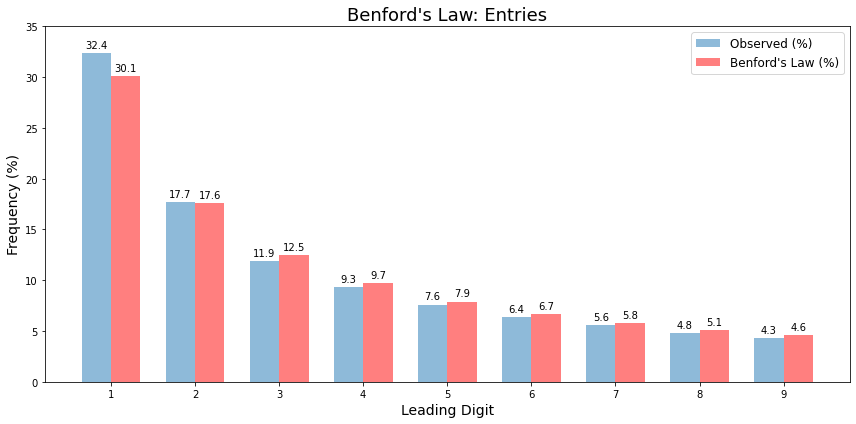

In [40]:
labels = list(range(1, 10))
observed = benford_ents_df['percent']
benford_percents = benford_ents_df['benfords']

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, observed, width, label='Observed (%)', alpha=0.5)
rects2 = ax.bar(x + width/2, benford_percents, width, label="Benford's Law (%)", color='red', alpha=0.5)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Frequency (%)', fontsize=14)
ax.set_xlabel('Leading Digit', fontsize=14)
ax.set_title("Benford's Law: Entries", fontsize=18)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim(0, 35)
ax.legend(fontsize=12)


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

#plt.savefig('entries.png')
plt.show();

This is almost spot on! 

Next I'll look at exits.

## Benford's Law Test: Exits

### Setting up the Exits DataFrame

In [41]:
benford_exits = benford_exits[['station', 'date', 'time', 'timestamp', 'weekday', 'weekday_num', 'ex_dig']]
benford_exits.head(3)

,station,date,time,timestamp,weekday,weekday_num,ex_dig
1,1 AV,2020-08-29,04:00:00,2020-08-29 04:00:00,Saturday,5,1
2,1 AV,2020-08-29,08:00:00,2020-08-29 08:00:00,Saturday,5,1
3,1 AV,2020-08-29,12:00:00,2020-08-29 12:00:00,Saturday,5,2


In [42]:
nums = list(range(1, 10))
benford_exits_count = list(benford_exits.ex_dig.value_counts())
benford_exits_df = pd.DataFrame({'digit': nums, 
                              'counts': benford_exits_count}, index=nums)
benford_exits_df

,digit,counts
1,1,212253
2,2,119059
3,3,84402
4,4,64321
5,5,52462
6,6,44039
7,7,37653
8,8,33093
9,9,29295


In [43]:
total_exits = benford_exits_df.counts.sum()
total_exits

676577

In [44]:
# Creating % Frequency Column
benford_exits_df['percent'] = benford_exits_df['counts'].apply(lambda x: (x / total_entries) * 100).round(decimals=1)

# Adding Benford's Law %s, and some calculation columns to see the difference
benford_exits_df['benfords'] = benfords['percent']
benford_exits_df['diff_abs'] = (benford_exits_df['percent'] - benford_exits_df['benfords']).abs()
benford_exits_df['diff_perc'] = (benford_exits_df['diff_abs'] / benford_exits_df['percent']) * 100

In [45]:
benford_exits_df

,digit,counts,percent,benfords,diff_abs,diff_perc
1,1,212253,33.2,30.1,3.1,9.337349
2,2,119059,18.6,17.6,1.0,5.376344
3,3,84402,13.2,12.5,0.7,5.303030
4,4,64321,10.1,9.7,0.4,3.960396
5,5,52462,8.2,7.9,0.3,3.658537
6,6,44039,6.9,6.7,0.2,2.898551
7,7,37653,5.9,5.8,0.1,1.694915
8,8,33093,5.2,5.1,0.1,1.923077
9,9,29295,4.6,4.6,0.0,0.000000


### Plotting Exits Results

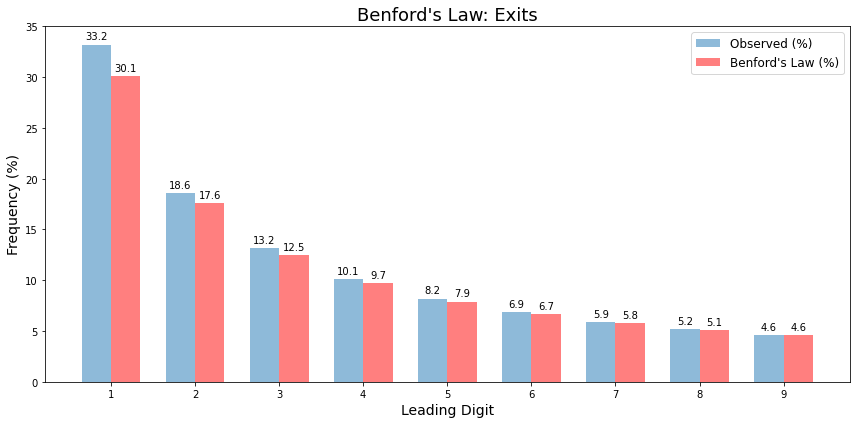

In [46]:
labels = list(range(1, 10))
observed = benford_exits_df['percent']
benford_percents = benford_exits_df['benfords']

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, observed, width, label='Observed (%)', alpha=0.5)
rects2 = ax.bar(x + width/2, benford_percents, width, label="Benford's Law (%)", color='red', alpha=0.5)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Frequency (%)', fontsize=14)
ax.set_xlabel('Leading Digit', fontsize=14)
ax.set_title("Benford's Law: Exits", fontsize=18)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim(0, 35)
ax.legend(fontsize=12)


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

#plt.savefig('exits.png')
plt.show();

Exits are also very *Benfordy*. 

Onto total traffic for these turnstiles: `entries + exits`

## Benford's Law Test: Total

### Setting up the Total DataFrame

In [47]:
benford_total = benford_total[['station', 'date', 'time', 'timestamp', 'weekday', 'weekday_num', 'total_dig']]
benford_total.head(3)

,station,date,time,timestamp,weekday,weekday_num,total_dig
1,1 AV,2020-08-29,04:00:00,2020-08-29 04:00:00,Saturday,5,1
2,1 AV,2020-08-29,08:00:00,2020-08-29 08:00:00,Saturday,5,1
3,1 AV,2020-08-29,12:00:00,2020-08-29 12:00:00,Saturday,5,2


In [48]:
nums = list(range(1, 10))
benford_total_count = list(benford_total.total_dig.value_counts())
benford_total_df = pd.DataFrame({'digit': nums, 
                              'counts': benford_total_count}, index=nums)
benford_total_df

,digit,counts
1,1,229298
2,2,129446
3,3,85001
4,4,62491
5,5,50722
6,6,42950
7,7,37620
8,8,33791
9,9,31080


In [49]:
total_total = benford_total_df.counts.sum()
total_total

702399

In [50]:
# Creating % Frequency Column
benford_total_df['percent'] = benford_total_df['counts'].apply(lambda x: (x / total_entries) * 100).round(decimals=1)

# Adding Benford's Law %s, and some calculation columns to see the difference
benford_total_df['benfords'] = benfords['percent']
benford_total_df['diff_abs'] = (benford_total_df['percent'] - benford_total_df['benfords']).abs()
benford_total_df['diff_perc'] = (benford_total_df['diff_abs'] / benford_total_df['percent']) * 100

In [51]:
benford_total_df

,digit,counts,percent,benfords,diff_abs,diff_perc
1,1,229298,35.9,30.1,5.8,16.155989
2,2,129446,20.2,17.6,2.6,12.871287
3,3,85001,13.3,12.5,0.8,6.015038
4,4,62491,9.8,9.7,0.1,1.020408
5,5,50722,7.9,7.9,0.0,0.000000
6,6,42950,6.7,6.7,0.0,0.000000
7,7,37620,5.9,5.8,0.1,1.694915
8,8,33791,5.3,5.1,0.2,3.773585
9,9,31080,4.9,4.6,0.3,6.122449


### Plotting the Results

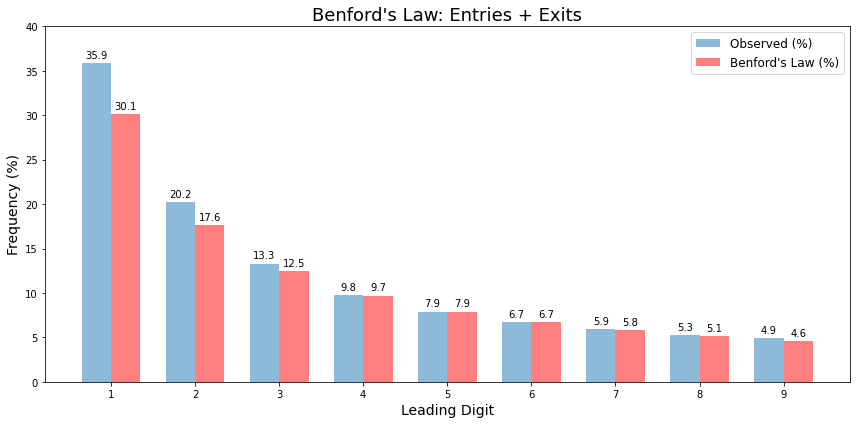

In [52]:
labels = list(range(1, 10))
observed = benford_total_df['percent']
benford_percents = benford_total_df['benfords']

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, observed, width, label='Observed (%)', alpha=0.5)
rects2 = ax.bar(x + width/2, benford_percents, width, label="Benford's Law (%)", color='red', alpha=0.5)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Frequency (%)', fontsize=14)
ax.set_xlabel('Leading Digit', fontsize=14)
ax.set_title("Benford's Law: Entries + Exits", fontsize=18)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim(0, 40)
ax.legend(fontsize=12)


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

#plt.savefig('total.png')
plt.show();

The frequency of leading 1's and 2's start to drift away from Benford's, but the curve is the same shape and we still don't see any larger leading digits with higher frequencies than smaller leading digits. I'd say this is still pretty *Benfordy*.

## Station Comparison: Time Square - 42nd St <> Prospect Av

Now I'll take a look at a couple individual stations. I've chosen two very different stations in terms of their activity levels: 
* Times Square - 42nd Street Station 
* Prospect Av (in Brooklyn)

The main idea for these two is to determine whether large stations with tons of traffic are biasing the data. So we'll take the ultimate high-traffic Manhattan station and compare to a smaller, neighborhoody station in Brooklyn.

### Time Square - 42nd Street Station

#### Setting up the Total DataFrame

In [53]:
timessquare = mta[(mta['ent_dig'] > 0) & 
                 (mta['station'] == 'TIMES SQ-42 ST')]
timessquare.head(3)

,station,ca,unit,scp,linename,division,date,time,timestamp,weekday,weekday_num,entries,exits,total,ent_dig,ex_dig,total_dig
784858,TIMES SQ-42 ST,A021,R032,01-00-00,ACENQRS1237W,BMT,2020-08-29,04:00:00,2020-08-29 04:00:00,Saturday,5,6.0,10.0,16.0,6,1,1
784859,TIMES SQ-42 ST,A021,R032,01-00-00,ACENQRS1237W,BMT,2020-08-29,08:00:00,2020-08-29 08:00:00,Saturday,5,18.0,58.0,76.0,1,5,7
784860,TIMES SQ-42 ST,A021,R032,01-00-00,ACENQRS1237W,BMT,2020-08-29,12:00:00,2020-08-29 12:00:00,Saturday,5,61.0,166.0,227.0,6,1,2


In [54]:
timessquare = timessquare[['date', 'timestamp', 'weekday_num', 'ent_dig']]
timessquare.head(3)

,date,timestamp,weekday_num,ent_dig
784858,2020-08-29,2020-08-29 04:00:00,5,6
784859,2020-08-29,2020-08-29 08:00:00,5,1
784860,2020-08-29,2020-08-29 12:00:00,5,6


In [55]:
nums = list(range(1, 10))
ts_ents_count = list(timessquare.ent_dig.value_counts())
timessquare = pd.DataFrame({'digit': nums, 
                              'counts': ts_ents_count}, index=nums)
timessquare

,digit,counts
1,1,2005
2,2,1155
3,3,763
4,4,616
5,5,478
6,6,473
7,7,415
8,8,309
9,9,288


In [56]:
ts_total_entries = timessquare.counts.sum()
ts_total_entries

6502

In [57]:
# Creating % Frequency Column
timessquare['percent'] = timessquare['counts'].apply(lambda x: (x / ts_total_entries) * 100).round(decimals=1)

# Adding Benford's Law %s, and some calculation columns to see the difference
timessquare['benfords'] = benfords['percent']
timessquare['diff_abs'] = (timessquare['percent'] - timessquare['benfords']).abs()
timessquare['diff_perc'] = ((timessquare['diff_abs'] / timessquare['percent']) * 100)

In [58]:
timessquare

,digit,counts,percent,benfords,diff_abs,diff_perc
1,1,2005,30.8,30.1,0.7,2.272727
2,2,1155,17.8,17.6,0.2,1.123596
3,3,763,11.7,12.5,0.8,6.837607
4,4,616,9.5,9.7,0.2,2.105263
5,5,478,7.4,7.9,0.5,6.756757
6,6,473,7.3,6.7,0.6,8.219178
7,7,415,6.4,5.8,0.6,9.375000
8,8,309,4.8,5.1,0.3,6.250000
9,9,288,4.4,4.6,0.2,4.545455


#### Plotting the Results

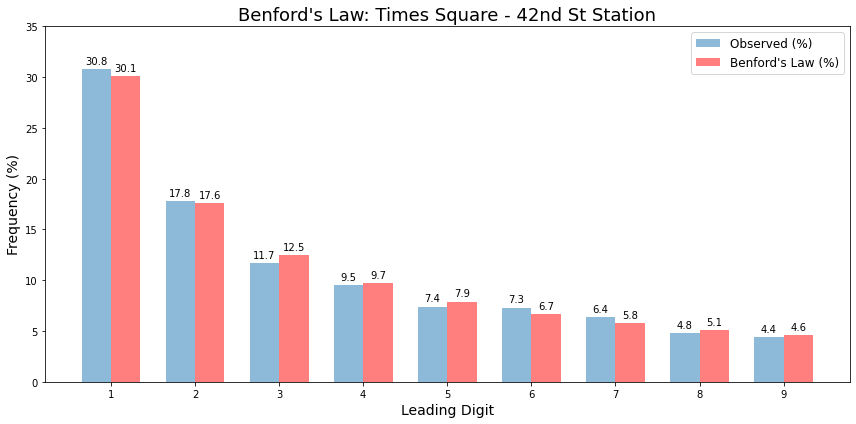

In [59]:
labels = list(range(1, 10))
observed = timessquare['percent']
benford_percents = benford_total_df['benfords']

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, observed, width, label='Observed (%)', alpha=0.5)
rects2 = ax.bar(x + width/2, benford_percents, width, label="Benford's Law (%)", color='red', alpha=0.5)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Frequency (%)', fontsize=14)
ax.set_xlabel('Leading Digit', fontsize=14)
ax.set_title("Benford's Law: Times Square - 42nd St Station", fontsize=18)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim(0, 35)
ax.legend(fontsize=12)


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

#plt.savefig('timessquare.png')
plt.show();

Time Square fits the pattern - let's check out Prospect Av station.

### Prospect Av Station

#### Setting up the Total DataFrame

In [60]:
prospect = mta[(mta['ent_dig'] > 0) & 
                 (mta['station'] == 'PROSPECT AV')]
prospect.head(3)

,station,ca,unit,scp,linename,division,date,time,timestamp,weekday,weekday_num,entries,exits,total,ent_dig,ex_dig,total_dig
731932,PROSPECT AV,C014,R246,00-00-00,R,BMT,2020-08-29,04:00:00,2020-08-29 04:00:00,Saturday,5,1.0,4.0,5.0,1,4,5
731933,PROSPECT AV,C014,R246,00-00-00,R,BMT,2020-08-29,08:00:00,2020-08-29 08:00:00,Saturday,5,14.0,25.0,39.0,1,2,3
731934,PROSPECT AV,C014,R246,00-00-00,R,BMT,2020-08-29,12:00:00,2020-08-29 12:00:00,Saturday,5,45.0,48.0,93.0,4,4,9


In [61]:
prospect = prospect[['date', 'timestamp', 'weekday_num', 'ent_dig']]
prospect.head(3)

,date,timestamp,weekday_num,ent_dig
731932,2020-08-29,2020-08-29 04:00:00,5,1
731933,2020-08-29,2020-08-29 08:00:00,5,1
731934,2020-08-29,2020-08-29 12:00:00,5,4


In [62]:
nums = list(range(1, 10))
prospect_ents_count = list(prospect.ent_dig.value_counts())
prospect = pd.DataFrame({'digit': nums, 
                              'counts': prospect_ents_count}, index=nums)
prospect

,digit,counts
1,1,529
2,2,318
3,3,216
4,4,177
5,5,135
6,6,135
7,7,112
8,8,91
9,9,85


In [63]:
prospect_total_entries = prospect.counts.sum()
prospect_total_entries

1798

In [64]:
# Creating % Frequency Column
prospect['percent'] = prospect['counts'].apply(lambda x: (x / prospect_total_entries) * 100).round(decimals=1)

# Adding Benford's Law %s, and some calculation columns to see the difference
prospect['benfords'] = benfords['percent']
prospect['diff_abs'] = (prospect['percent'] - prospect['benfords']).abs()
prospect['diff_perc'] = ((prospect['diff_abs'] / prospect['percent']) * 100)

In [65]:
prospect

,digit,counts,percent,benfords,diff_abs,diff_perc
1,1,529,29.4,30.1,0.7,2.380952
2,2,318,17.7,17.6,0.1,0.564972
3,3,216,12.0,12.5,0.5,4.166667
4,4,177,9.8,9.7,0.1,1.020408
5,5,135,7.5,7.9,0.4,5.333333
6,6,135,7.5,6.7,0.8,10.666667
7,7,112,6.2,5.8,0.4,6.451613
8,8,91,5.1,5.1,0.0,0.000000
9,9,85,4.7,4.6,0.1,2.127660


#### Plotting the Results

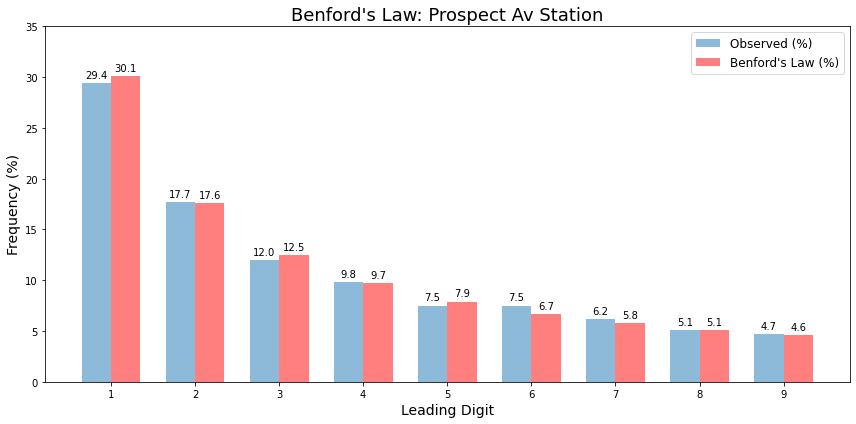

In [66]:
labels = list(range(1, 10))
observed = prospect['percent']
benford_percents = benford_total_df['benfords']

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, observed, width, label='Observed (%)', alpha=0.5)
rects2 = ax.bar(x + width/2, benford_percents, width, label="Benford's Law (%)", color='red', alpha=0.5)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Frequency (%)', fontsize=14)
ax.set_xlabel('Leading Digit', fontsize=14)
ax.set_title("Benford's Law: Prospect Av Station", fontsize=18)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim(0, 35)
ax.legend(fontsize=12)


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

#plt.savefig('prospectav.png')
plt.show();

Prospect Av station is quite *Benfordy* too.

Let's take a quick side by side look.

### Station Comparison

#### Table Comparison

In [67]:
benford_compare = benfords

benford_compare.columns = ['digit', 'benfords']

In [68]:
benford_compare['ts_perc'] = timessquare['percent']
benford_compare['prosp_perc'] = prospect['percent']

benford_compare

,digit,benfords,ts_perc,prosp_perc
1,1,30.1,30.8,29.4
2,2,17.6,17.8,17.7
3,3,12.5,11.7,12.0
4,4,9.7,9.5,9.8
5,5,7.9,7.4,7.5
6,6,6.7,7.3,7.5
7,7,5.8,6.4,6.2
8,8,5.1,4.8,5.1
9,9,4.6,4.4,4.7


#### Side by Side Plots

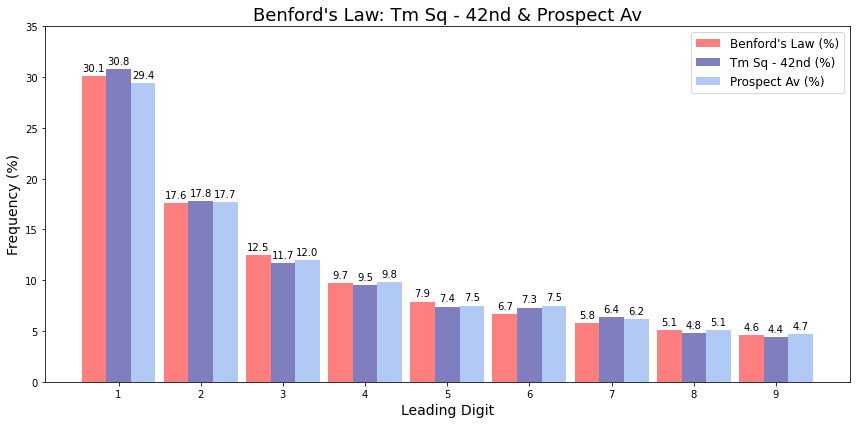

In [69]:
labels = list(range(1, 10))
prospect_percent = prospect['percent']
timessquare_percent = timessquare['percent']
benford_percents = benford_total_df['benfords']

x = np.arange(len(labels))  # the label locations
width = 0.45  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 6))

rects1 = ax.bar(x - width/1.5, benford_percents, width/1.5, label="Benford's Law (%)", color='red', alpha=0.5)
rects2 = ax.bar(x, timessquare_percent, width/1.5, label='Tm Sq - 42nd (%)', color='navy', alpha=0.5)
rects3 = ax.bar(x + width/1.5, prospect_percent, width/1.5, label='Prospect Av (%)', color='cornflowerblue', alpha=0.5)


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Frequency (%)', fontsize=14)
ax.set_xlabel('Leading Digit', fontsize=14)
ax.set_title("Benford's Law: Tm Sq - 42nd & Prospect Av", fontsize=18)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim(0, 35)
ax.legend(fontsize=12)


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()

#plt.savefig('tmsq_prospect.png')
plt.show();

These two stations line up nicely. There are a few instances where Times Square fits better, and others where Prospect Av does. I think using eye-ball statistics we can call it a wash.

## Summary

### Observations

Every view above seems to fit Benford's Law and this raises a beautiful idea that could be better supported with further analysis: the entire MTA subway system shares the same properties as Fibonacci numbers, stock market values, income tax data, and other natural sciences data. 

It makes me think of the NYC subway system as this living organism that obeys certain natural laws just like any other. Our humanness is reflected in the data.

### Suggestions for Further Analysis

This is a fun first start! There is plenty of further analysis to be done. 

Here are some suggestions:

* Compare all stations for Benford-ness
    * Compare variance from Benford's Law
    * Rank stations by best fit to Benford's
* Sample other time periods
    * Smaller sample: 1 week
    * Large sample: + 4 weeks
* Test individual turnstiles for Benford-ness    
    